# CNN using coronary heart disease data 

This work is aiming at the design and testing of a deep neural network architecture on Coronary heart disease using Tensorflow and Keras.

## Importing libraries

In [126]:
import numpy as np
import copy
from sklearn import preprocessing

In [127]:
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
from matplotlib import pyplot as plt
from numpy.random import seed
np.random.seed(2095)

## Reading the data

In [128]:
# read input file
file = '/Users/lhlforever/Heart-Disease-Prediction/Heart-Disease-Prediction/CardiacPrediction.xlsx'
#ipData = pd.read_excel(file, sheet_name='Stroke')
ipData = pd.read_excel(file, sheet_name='CoroHeartDis')
print(ipData.columns) 

Index(['SEQN', 'Gender', 'Age', 'Annual-Family-Income',
       'Ratio-Family-Income-Poverty', 'X60-sec-pulse', 'Systolic', 'Diastolic',
       'Weight', 'Height', 'Body-Mass-Index', 'White-Blood-Cells',
       'Lymphocyte', 'Monocyte', 'Eosinophils', 'Basophils', 'Red-Blood-Cells',
       'Hemoglobin', 'Mean-Cell-Vol', 'Mean-Cell-Hgb-Conc.',
       'Mean-cell-Hemoglobin', 'Platelet-count', 'Mean-Platelet-Vol',
       'Segmented-Neutrophils', 'Hematocrit', 'Red-Cell-Distribution-Width',
       'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol', 'Creatinine', 'Glucose',
       'GGT', 'Iron', 'LDH', 'Phosphorus', 'Bilirubin', 'Protein', 'Uric.Acid',
       'Triglycerides', 'Total-Cholesterol', 'HDL', 'Glycohemoglobin',
       'Vigorous-work', 'Moderate-work', 'Health-Insurance', 'Diabetes',
       'Blood-Rel-Diabetes', 'Blood-Rel-Stroke', 'CoronaryHeartDisease'],
      dtype='object')


## Drop variables

In [129]:
# data drop
opLabel = np.array(ipData['CoronaryHeartDisease'])
ipData.drop(['SEQN','CoronaryHeartDisease','Annual-Family-Income','Height','Ratio-Family-Income-Poverty','X60-sec-pulse',
          'Health-Insurance','Lymphocyte','Monocyte','Eosinophils','Total-Cholesterol','Mean-Cell-Vol','Mean-Cell-Hgb-Conc.','Hematocrit','Segmented-Neutrophils'], axis = 1, inplace=True)


#opLabel = np.array(ipData['Stroke'])
#ipData.drop(['SEQN','Stroke','Annual-Family-Income','Height','Ratio-Family-Income-Poverty','X60-sec-pulse',
#          'Health-Insurance','Lymphocyte','Monocyte','Eosinophils','Total-Cholesterol','Mean-Cell-Vol','Mean-Cell-Hgb-Conc.','Hematocrit','Segmented-Neutrophils'], axis = 1, inplace=True)



In [130]:
# dummy variable for categorical variables
ipData = pd.get_dummies(ipData,columns=["Gender","Diabetes","Blood-Rel-Diabetes","Blood-Rel-Stroke","Vigorous-work","Moderate-work"]) 

varb = np.array(ipData.columns)
ipData = np.array(ipData)

In [131]:
print(ipData.shape)
print(varb)
print(len(opLabel[opLabel==0]))
print(len(opLabel[opLabel==1]))

(37079, 45)
['Age' 'Systolic' 'Diastolic' 'Weight' 'Body-Mass-Index'
 'White-Blood-Cells' 'Basophils' 'Red-Blood-Cells' 'Hemoglobin'
 'Mean-cell-Hemoglobin' 'Platelet-count' 'Mean-Platelet-Vol'
 'Red-Cell-Distribution-Width' 'Albumin' 'ALP' 'AST' 'ALT' 'Cholesterol'
 'Creatinine' 'Glucose' 'GGT' 'Iron' 'LDH' 'Phosphorus' 'Bilirubin'
 'Protein' 'Uric.Acid' 'Triglycerides' 'HDL' 'Glycohemoglobin' 'Gender_1'
 'Gender_2' 'Diabetes_1' 'Diabetes_2' 'Diabetes_3' 'Blood-Rel-Diabetes_1'
 'Blood-Rel-Diabetes_2' 'Blood-Rel-Stroke_1' 'Blood-Rel-Stroke_2'
 'Vigorous-work_1' 'Vigorous-work_2' 'Vigorous-work_3' 'Moderate-work_1'
 'Moderate-work_2' 'Moderate-work_3']
35571
1508


## Feature Nomination using Ridge

In [132]:
from sklearn.linear_model import Ridge  # Import Ridge
from sklearn import preprocessing
import numpy as np

featureVote = np.zeros(ipData.shape[1])
print(featureVote.shape)

# Calculate sizes for train, test, and validation sets
total_size = ipData.shape[0]
train_size = int(0.70 * total_size)
test_size = val_size = int(0.15 * total_size)
iteR=100
for num in range(iteR):
    # Shuffle the indices for each label
    label0_indx = np.where(opLabel == 0)[0]
    label1_indx = np.where(opLabel == 1)[0]
    np.random.shuffle(label0_indx)
    np.random.shuffle(label1_indx)

    # Split indices into train, test, and validation sets for each label
    label0_indx_train = label0_indx[:train_size // 2]
    label1_indx_train = label1_indx[:train_size // 2]
    label0_indx_test = label0_indx[train_size // 2:train_size // 2 + test_size // 2]
    label1_indx_test = label1_indx[train_size // 2:train_size // 2 + test_size // 2]
    label0_indx_val = label0_indx[train_size // 2 + test_size // 2:train_size // 2 + test_size // 2 + val_size // 2]
    label1_indx_val = label1_indx[train_size // 2 + test_size // 2:train_size // 2 + test_size // 2 + val_size // 2]

    # Combine indices for each set
    trainIndx = np.append(label0_indx_train, label1_indx_train)
    testIndx = np.append(label0_indx_test, label1_indx_test)
    valIndx = np.append(label0_indx_val, label1_indx_val)

    # Select data for each set
    trainData = ipData[trainIndx]
    trainLabel = opLabel[trainIndx]
    testData = ipData[testIndx]
    testLabel = opLabel[testIndx]
    valData = ipData[valIndx]
    valLabel = opLabel[valIndx]

    # Data standardization
    scaler = preprocessing.StandardScaler().fit(trainData)
    trainData_scaled = scaler.transform(trainData)
    testData_scaled = scaler.transform(testData)
    valData_scaled = scaler.transform(valData)

    # Use Ridge instead of Lasso
    regr = Ridge(random_state=0, alpha=0.006, tol=0.000001, max_iter=100000)
    regr.fit(trainData_scaled, trainLabel)



(45,)


In [133]:
print(featureVote)
print(iter)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
<built-in function iter>


In [134]:
# feature nomination via Lasso (from feature 1 to 30)
# We keep the dummy variables

#thresH = iteR//5. Pick features occuring more than 5 times
thresH = 0
featureIndx = np.where(featureVote[0:30]>=thresH)[0]
featureIndx = np.append(featureIndx, np.arange(30,ipData.shape[1]))
print(varb[featureIndx])

['Age' 'Systolic' 'Diastolic' 'Weight' 'Body-Mass-Index'
 'White-Blood-Cells' 'Basophils' 'Red-Blood-Cells' 'Hemoglobin'
 'Mean-cell-Hemoglobin' 'Platelet-count' 'Mean-Platelet-Vol'
 'Red-Cell-Distribution-Width' 'Albumin' 'ALP' 'AST' 'ALT' 'Cholesterol'
 'Creatinine' 'Glucose' 'GGT' 'Iron' 'LDH' 'Phosphorus' 'Bilirubin'
 'Protein' 'Uric.Acid' 'Triglycerides' 'HDL' 'Glycohemoglobin' 'Gender_1'
 'Gender_2' 'Diabetes_1' 'Diabetes_2' 'Diabetes_3' 'Blood-Rel-Diabetes_1'
 'Blood-Rel-Diabetes_2' 'Blood-Rel-Stroke_1' 'Blood-Rel-Stroke_2'
 'Vigorous-work_1' 'Vigorous-work_2' 'Vigorous-work_3' 'Moderate-work_1'
 'Moderate-work_2' 'Moderate-work_3']


In [135]:
featureIndx.shape

(45,)

In [136]:
tInx = np.arange(ipData.shape[1])
rrInx = tInx[~np.isin(tInx,featureIndx)]
print(varb[rrInx])

[]


# Dataset reduction (Re-run every time you change the number of training data)

In [137]:
reduced_data = ipData[:,featureIndx]

label0_indx = np.where(opLabel==0)[0]   #no cardiac arrest
label1_indx = np.where(opLabel==1)[0]   #cardiac arrest 

# Calculate sizes for train, test, and validation sets
total_size0 = len(label0_indx)
total_size1 = len(label1_indx)
train_size0 = int(0.70 * total_size0)
train_size1 = int(0.70 * total_size1)
val_size0 = test_size0 = int(0.15 * total_size0)
val_size1 = test_size1 = int(0.15 * total_size1)

np.random.shuffle(label0_indx)
np.random.shuffle(label1_indx)

# Splitting indices into train, validation, and test sets
label0_indx_train = label0_indx[:train_size0]
label1_indx_train = label1_indx[:train_size1]
label0_indx_val = label0_indx[train_size0:train_size0 + val_size0]
label1_indx_val = label1_indx[train_size1:train_size1 + val_size1]
label0_indx_test = label0_indx[train_size0 + val_size0:]
label1_indx_test = label1_indx[train_size1 + val_size1:]

# Combine indices for each set
trainIndx = np.append(label0_indx_train, label1_indx_train)
valIndx = np.append(label0_indx_val, label1_indx_val)
testIndx = np.append(label0_indx_test, label1_indx_test)

# Select data for each set
x_train = reduced_data[trainIndx]
y_train = opLabel[trainIndx]
x_val = reduced_data[valIndx]
y_val = opLabel[valIndx]
x_test = reduced_data[testIndx]
y_test = opLabel[testIndx]


In [138]:
print(len(label0_indx_test))

5337


In [139]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Then proceed with scaling
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# Create deep copies
x_train_org = copy.deepcopy(x_train)
x_val_org = copy.deepcopy(x_val)
x_test_org = copy.deepcopy(x_test)
y_train_org = copy.deepcopy(y_train)
y_val_org = copy.deepcopy(y_val)
y_test_org = copy.deepcopy(y_test)


## t-SNE visualization

In [140]:
# t-SNE visualization
import imblearn
from collections import Counter
from sklearn.manifold import TSNE
import seaborn as sns

In [141]:
X_embedded = TSNE(n_components=3, n_iter = 300, verbose=1).fit_transform(x_train)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25954 samples in 0.000s...


[t-SNE] Computed neighbors for 25954 samples in 0.937s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25954
[t-SNE] Computed conditional probabilities for sample 2000 / 25954
[t-SNE] Computed conditional probabilities for sample 3000 / 25954
[t-SNE] Computed conditional probabilities for sample 4000 / 25954
[t-SNE] Computed conditional probabilities for sample 5000 / 25954
[t-SNE] Computed conditional probabilities for sample 6000 / 25954
[t-SNE] Computed conditional probabilities for sample 7000 / 25954
[t-SNE] Computed conditional probabilities for sample 8000 / 25954
[t-SNE] Computed conditional probabilities for sample 9000 / 25954
[t-SNE] Computed conditional probabilities for sample 10000 / 25954
[t-SNE] Computed conditional probabilities for sample 11000 / 25954
[t-SNE] Computed conditional probabilities for sample 12000 / 25954
[t-SNE] Computed conditional probabilities for sample 13000 / 25954
[t-SNE] Computed conditional probabilities for sample 14000 / 25954

/var/folders/gp/y2m6w9cs0l903346k_cz_31w0000gn/T/ipykernel_844/505496209.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(0,0,0,c=cin,edgecolors='k',label='CHD')


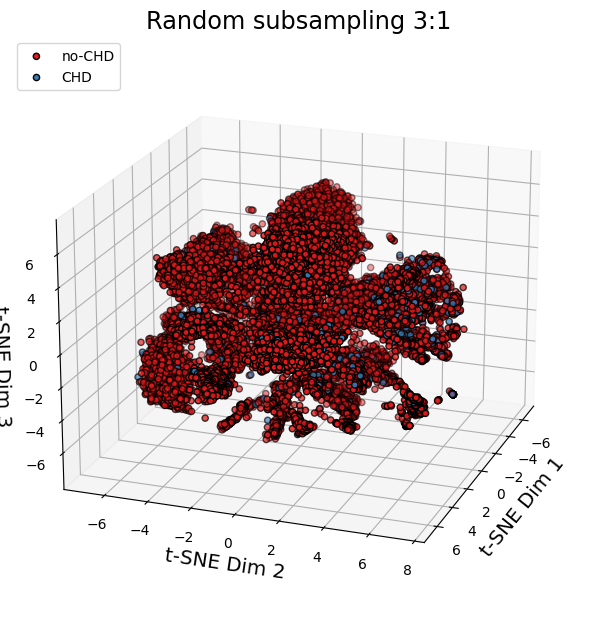

In [142]:
from mpl_toolkits.mplot3d import Axes3D

cin = sns.color_palette("Set1")[1]
edge_color = []
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('w')
ax.scatter(X_embedded[:,0],X_embedded[:,1],X_embedded[:,2],c=[sns.color_palette("Set1")[x] for x in y_train],\
           edgecolors='k',label='no-CHD')
ax.scatter(0,0,0,c=cin,edgecolors='k',label='CHD')
ax.azim = 20
ax.elev = 20
ax.set_xlabel("t-SNE Dim 1", size="x-large")
ax.set_ylabel("t-SNE Dim 2", size="x-large")
ax.set_zlabel("t-SNE Dim 3", size="x-large")
plt.title("Random subsampling 3:1",size="xx-large")
ax.legend(loc='upper left')
fig.set_size_inches(7.5,7.5)
fig.savefig('tSNE_RUS.png', dpi=100)

In [143]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [144]:
#%% one-hot-encoding
y_train = keras.utils.to_categorical(y_train,2)
y_test  = keras.utils.to_categorical(y_test,2)

In [145]:
#y_train.shape
#y_train
y_train_org

array([0, 0, 0, ..., 1, 1, 1])

# Running the part above is MANDATORY for training any Network below

# Introducing convolutional layers

## MLP+Conv :: Input => Hidden(128)  => Conv(4) => Output (2)

In [146]:

inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((128,1))(DP0)
FC1    = keras.layers.Conv1D(4,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1 = keras.layers.MaxPool1D(pool_size=2)(AC1)
FL1   = keras.layers.Flatten()(Pool1)

FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(FL1)
outputs = keras.layers.Activation('softmax')(FC3)

myCNN1D1 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D1.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN1D1.summary()


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 45, 1)]           0         
                                                                 
 reshape_26 (Reshape)        (None, 45)                0         
                                                                 
 dense_30 (Dense)            (None, 128)               5888      
                                                                 
 batch_normalization_40 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 activation_52 (Activation)  (None, 128)               0         
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                          

In [147]:
class_weight = {0: 1, 1: 4}

myCNN1D1.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

812/812 [==============================] - 1s 1ms/step - loss: 0.3830 - accuracy: 0.9311


In [148]:
test_loss,test_acc = myCNN1D1.evaluate(x_test,y_test)
print(test_acc)

174/174 [==============================] - 0s 558us/step - loss: 0.1585 - accuracy: 0.9473
0.9473400712013245


In [149]:
from sklearn import metrics
predlabel = myCNN1D1.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

174/174 [==============================] - 0s 479us/step
[[5241   96]
 [ 197   30]]


##  MLP+CONV: Input => Hidden(128)  => Conv(4) => Conv(8) => Output (2)

In [150]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((128,1))(DP0)
FC1    = keras.layers.Conv1D(4,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1 = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FC2    = keras.layers.Conv1D(8,5,strides=1)(Pool1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool2 = keras.layers.AveragePooling1D(pool_size=2)(AC2)

FL1   = keras.layers.Flatten()(Pool2)

FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(FL1)
outputs = keras.layers.Activation('softmax')(FC3)

myCNN1D2 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D2.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN1D2.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 45, 1)]           0         
                                                                 
 reshape_28 (Reshape)        (None, 45)                0         
                                                                 
 dense_32 (Dense)            (None, 128)               5888      
                                                                 
 batch_normalization_42 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 activation_55 (Activation)  (None, 128)               0         
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                          

In [151]:
class_weight = {0: 1, 1: 4.5}

myCNN1D2.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

812/812 [==============================] - 2s 2ms/step - loss: 0.4085 - accuracy: 0.9318


In [152]:
test_loss,test_acc = myCNN1D2.evaluate(x_test,y_test)
print(test_acc)

174/174 [==============================] - 0s 691us/step - loss: 0.1949 - accuracy: 0.9346
0.9345794320106506


In [153]:
from sklearn import metrics
predlabel = myCNN1D2.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

174/174 [==============================] - 0s 626us/step
[[5134  203]
 [ 161   66]]


## MLP+Conv :: Input => Hidden(64) => Conv(2) => Hidden(512)  

In [154]:

inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(32, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((32,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1 = keras.layers.MaxPool1D(pool_size=2)(AC1)
FL1   = keras.layers.Flatten()(Pool1)

FC2    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
#DP2    = keras.layers.Dropout(0.2)(AC2)


FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(AC2)
outputs = keras.layers.Activation('softmax')(FC3)

myCNN1D3 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D3.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
myCNN1D3.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 45, 1)]           0         
                                                                 
 reshape_30 (Reshape)        (None, 45)                0         
                                                                 
 dense_34 (Dense)            (None, 32)                1472      
                                                                 
 batch_normalization_45 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 activation_59 (Activation)  (None, 32)                0         
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                          

In [155]:
class_weight = {0: 1, 1: 50}

myCNN1D3.fit(x_train,y_train,epochs=5,verbose=1, class_weight=class_weight)

Epoch 1/5
812/812 [==============================] - 2s 1ms/step - loss: 1.7676 - accuracy: 0.5002
Epoch 2/5
812/812 [==============================] - 1s 1ms/step - loss: 1.4697 - accuracy: 0.5811
Epoch 3/5
812/812 [==============================] - 1s 1ms/step - loss: 1.3376 - accuracy: 0.6190
Epoch 4/5
812/812 [==============================] - 1s 1ms/step - loss: 1.3413 - accuracy: 0.6148
Epoch 5/5
812/812 [==============================] - 1s 1ms/step - loss: 1.2831 - accuracy: 0.6325


In [156]:
test_loss,test_acc = myCNN1D3.evaluate(x_test,y_test)
print(test_acc)

174/174 [==============================] - 0s 475us/step - loss: 0.6493 - accuracy: 0.6517
0.6516894102096558


In [157]:
from sklearn import metrics
predlabel = myCNN1D3.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

174/174 [==============================] - 0s 416us/step
[[3423 1914]
 [  24  203]]


## MLP+ CONV: Input => Dense(64) => Conv(2) => Conv(4) = Dense(512) => Dense (2) [Best model]

In [158]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(64, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((64,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1  = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FC2    = keras.layers.Conv1D(4,5,strides=1)(Pool1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool2  = keras.layers.AveragePooling1D(pool_size=2)(AC2)

FL1    = keras.layers.Flatten()(Pool2)

FC3    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
BN3    = keras.layers.BatchNormalization(axis=-1)(FC3)
AC3    = keras.layers.Activation('relu')(BN3)
DP3    = keras.layers.Dropout(0.2)(AC3)


FC4    = keras.layers.Dense(2)(DP3)
outputs = keras.layers.Activation('softmax')(FC4)

myCNN1D4 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D4.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

#myCNN1D4.summary()

In [159]:
class_weight = {0: 1, 1: 2.9}

myCNN1D4.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

812/812 [==============================] - 2s 2ms/step - loss: 0.3696 - accuracy: 0.9373


In [160]:
test_loss,test_acc = myCNN1D4.evaluate(x_test,y_test)
print(test_acc)

174/174 [==============================] - 0s 622us/step - loss: 0.1760 - accuracy: 0.9439
0.9439252614974976


In [161]:
from sklearn import metrics
predlabel = myCNN1D4.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

174/174 [==============================] - 0s 575us/step
[[5208  129]
 [ 183   44]]


In [162]:
y_train @ np.transpose(np.array([0, 1]))
1/41

0.024390243902439025

## Input => Dense(64) => Conv(2) => Conv(4) = Conv(8) => Dense (2)

In [163]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(64, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((64,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1  = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FC2    = keras.layers.Conv1D(4,5,strides=1)(Pool1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool2  = keras.layers.AveragePooling1D(pool_size=2)(AC2)


FC3    = keras.layers.Conv1D(6,7,strides=1)(Pool2)
BN3    = keras.layers.BatchNormalization(axis=-1)(FC3)
AC3    = keras.layers.Activation('relu')(BN3)
Pool3  = keras.layers.AveragePooling1D(pool_size=2)(AC3)




FL1    = keras.layers.Flatten()(Pool3)

#FC3    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
#BN3    = keras.layers.BatchNormalization(axis=-1)(FC3)
#AC3    = keras.layers.Activation('relu')(BN3)
#DP3    = keras.layers.Dropout(0.2)(AC3)


FC4    = keras.layers.Dense(2)(FL1)
outputs = keras.layers.Activation('softmax')(FC4)

myCNN5D4 = keras.Model(inputs=inputs,outputs=outputs)
myCNN5D4.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN5D4.summary()


Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 45, 1)]           0         
                                                                 
 reshape_34 (Reshape)        (None, 45)                0         
                                                                 
 dense_40 (Dense)            (None, 64)                2944      
                                                                 
 batch_normalization_52 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 activation_68 (Activation)  (None, 64)                0         
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                          

In [164]:
class_weight = {0: 1, 1: 3.0}

myCNN5D4.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

812/812 [==============================] - 2s 2ms/step - loss: 0.3267 - accuracy: 0.9502


In [165]:
test_loss,test_acc = myCNN5D4.evaluate(x_test,y_test)
print(test_acc)

174/174 [==============================] - 0s 689us/step - loss: 0.1712 - accuracy: 0.9506
0.9505751132965088


In [166]:
from sklearn import metrics
predlabel = myCNN5D4.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

174/174 [==============================] - 0s 644us/step
[[5260   77]
 [ 198   29]]


## Input => Dense(64) => Conv(2) => Dense (128) = Conv(4) => Dense (2)

In [167]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(64, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((64,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1  = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FL0 = keras.layers.Flatten()(Pool1)

AA1 = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(FL0)
BB1 = keras.layers.BatchNormalization(axis=-1)(AA1)
CC1 = keras.layers.Activation('relu')(BB1)
Pool2 = keras.layers.Dropout(0.2)(CC1)


RS2    = keras.layers.Reshape((128,1))(Pool2)
FC2    = keras.layers.Conv1D(4,5,strides=1)(RS2)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool3  = keras.layers.AveragePooling1D(pool_size=2)(AC2)



FL1    = keras.layers.Flatten()(Pool3)

#FC3    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
#BN3    = keras.layers.BatchNormalization(axis=-1)(FC3)
#AC3    = keras.layers.Activation('relu')(BN3)
#DP3    = keras.layers.Dropout(0.2)(AC3)


FC4    = keras.layers.Dense(2)(FL1)
outputs = keras.layers.Activation('softmax')(FC4)

myCNN5D4 = keras.Model(inputs=inputs,outputs=outputs)
myCNN5D4.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN5D4.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 45, 1)]           0         
                                                                 
 reshape_36 (Reshape)        (None, 45)                0         
                                                                 
 dense_42 (Dense)            (None, 64)                2944      
                                                                 
 batch_normalization_56 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 activation_73 (Activation)  (None, 64)                0         
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                          

In [168]:
class_weight = {0: 1, 1: 2.5}

myCNN5D4.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

812/812 [==============================] - 2s 2ms/step - loss: 0.2884 - accuracy: 0.9463


In [169]:
test_loss,test_acc = myCNN5D4.evaluate(x_test,y_test)
print(test_acc)

174/174 [==============================] - 0s 737us/step - loss: 0.1726 - accuracy: 0.9450
0.9450035691261292


In [170]:
from sklearn import metrics
predlabel = myCNN5D4.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

174/174 [==============================] - 0s 666us/step
[[5220  117]
 [ 189   38]]


# Running SVM on the subsampled data

In [171]:
from sklearn.svm import SVC
from sklearn import metrics

svcCAD = SVC(C=0.05, gamma=1/41, kernel='rbf', class_weight='balanced')
svcCAD.fit(x_train_org, y_train_org)
predlabel = svcCAD.predict(x_test_org)

# Confusion matrix
confMat = metrics.confusion_matrix(y_test_org, predlabel)
print("Confusion Matrix:")
print(confMat)

# Calculating accuracy
accuracy = metrics.accuracy_score(y_test_org, predlabel)
print("Accuracy: {:.2f}%".format(accuracy * 100))



Confusion Matrix:
[[3942 1395]
 [  39  188]]
Accuracy: 74.23%


# Running KNN on the subsampled data

In [172]:
# Running KNN on the subsampled data
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

knn = KNeighborsClassifier(n_neighbors=2)  
knn.fit(x_train_org, y_train_org)
predlabel = knn.predict(x_test_org)

# Confusion matrix
confMat = metrics.confusion_matrix(y_test_org, predlabel)
print("Confusion Matrix:")
print(confMat)

# Calculating accuracy
accuracy = metrics.accuracy_score(y_test_org, predlabel)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Confusion Matrix:
[[5328    9]
 [ 224    3]]
Accuracy: 95.81%


# Running Vote on the subsampled data

In [173]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(C=0.05, gamma=1/41, kernel='rbf', probability=True)  # probability must be True for soft voting
dt = DecisionTreeClassifier()

# Create a voting classifier
voting_clf = VotingClassifier(estimators=[('knn', knn), ('svm', svm), ('dt', dt)], voting='hard') 
voting_clf.fit(x_train_org, y_train_org)
predlabel = voting_clf.predict(x_test_org)

# Confusion matrix
confMat = metrics.confusion_matrix(y_test_org, predlabel)
print("Confusion Matrix:")
print(confMat)

# Calculating accuracy
accuracy = metrics.accuracy_score(y_test_org, predlabel)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Confusion Matrix:
[[5335    2]
 [ 224    3]]
Accuracy: 95.94%


#Running KNN on Validation data


In [174]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit(trainData_scaled, trainLabel)  # Use the training data
predlabel = knn.predict(valData_scaled)  # Predict on the validation set

# Confusion matrix
confMat = metrics.confusion_matrix(valLabel, predlabel)
print("Confusion Matrix:")
print(confMat)

# Calculating accuracy
accuracy = metrics.accuracy_score(valLabel, predlabel)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Confusion Matrix:
[[2721   59]
 [   0    0]]
Accuracy: 97.88%


Running Voting method on Validation dataset

In [175]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Assuming valData_scaled and valLabel are defined and prepared
svm = SVC(C=0.05, gamma=1/41, kernel='rbf', probability=True)
dt = DecisionTreeClassifier()
voting_clf = VotingClassifier(estimators=[('knn', knn), ('svm', svm), ('dt', dt)], voting='hard')

voting_clf.fit(trainData_scaled, trainLabel)  # Use the training data
predlabel = voting_clf.predict(valData_scaled)  # Predict on the validation set

# Confusion matrix
confMat = metrics.confusion_matrix(valLabel, predlabel)
print("Confusion Matrix:")
print(confMat)

# Calculating accuracy
accuracy = metrics.accuracy_score(valLabel, predlabel)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Confusion Matrix:
[[2758   22]
 [   0    0]]
Accuracy: 99.21%
